In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/wombat_peaks.csv")

In [3]:
df = df.sort_values(by=["r_peak"])

## Grouping

Unlike many of the papers featured in fatigue detection, our data involves constant breaks and noise. When calculating the HRV, it is important that the RR interval is not calculated for peaks very far apart. Additionally, the peak detection is not perfect, and so short intervals should also be ignored.

If two peaks fall out of the range 40 < x < 120 BPM then it is grouped seperately. Additionally, an outlier value is also considered a break in the group. Outliers are determined based on a z-score value with a threshold of 2.5 for when a group has more than two elements

In [71]:
import numpy as np

def process_group(group, threshold=2.5):
    """
    Finds outliers in group and replaces it
    """
    mean = np.mean(group)
    std = np.std(group)
    for i in range(len(group)):
        z = abs((group[i] - mean) / std)
        if z >= threshold:
            group[i] = mean
    return group
            
        

def group_peaks(peaks, min_bpm=50, max_bpm=115):
    groups = []
    current_group = []
    for i in range(len(peaks)-1):
        p1 = peaks[i]
        p2 = peaks[i+1]
        rr = p2 - p1
        bpm = rr / 300 * 60
        if min_bpm < bpm and bpm < max_bpm:
            current_group.append(rr)
        else:
            if current_group is not None:
                if len(current_group) >= 3:
                    groups.append(process_group(current_group))
                current_group = []
    if current_group is not None:
        groups.append(current_group)
    return groups

In [72]:
rr_groups = group_peaks(list(df["r_peak"]))

In [73]:
flatten = lambda l: [item for sublist in l for item in sublist]
rr_flat = flatten(rr_groups)

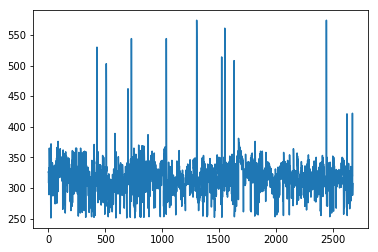

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rr_flat)

## Remove Outliers
Further outliers need to be removed that were not discovered during grouping

In [75]:
rr_mean = np.mean(rr_flat)
rr_std = np.std(rr_flat)
print(rr_mean)
print(rr_std)

318.43737915192503
27.745806769139218


In [76]:
rr_sans_outliers = [x for x in rr_flat if abs((x - rr_mean) / rr_std) <= 2.5]

In [77]:
def windowed_average(a, n=3):
    a = np.pad(a, [1, n-2], mode="mean")
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

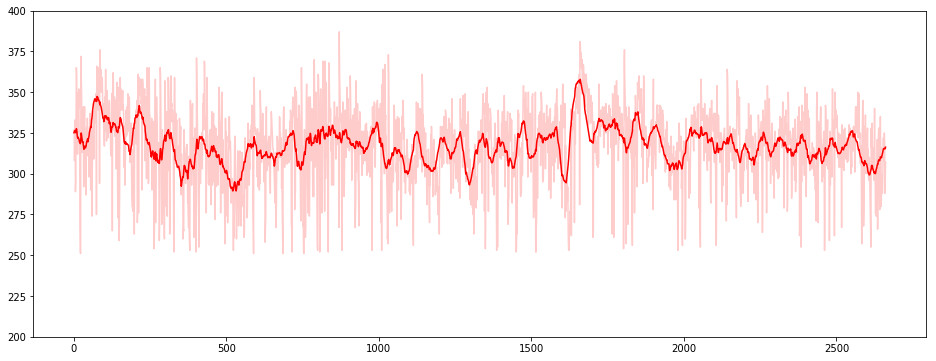

In [78]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_ylim((200, 400))
ax.plot(rr_sans_outliers, "r", alpha=0.2)
ax.plot(windowed_average(rr_sans_outliers, 30), "r")

In [79]:
import math

def get_rmssd_hrv(rr, sections=3):
        hrv_total = []
        hrv_sections = []
        for j in range(len(rr) // sections):
            values = rr[j*sections:j*sections+sections]
            rr_delta = []
            for i in range(len(values)-1):
                d = (values[i] - values[i+1]) ** 2
                rr_delta.append(d)
            hrv = math.sqrt(1 / (len(values)-2) * sum(rr_delta))
            hrv_sections.append(hrv)

        for i in range(len(rr)-1):
            d = (rr[i] - rr[i+1]) ** 2
            hrv_total.append(d)
        hrv = math.sqrt(1 / (len(rr)-2) * sum(hrv_total))
        return hrv, hrv_sections

In [80]:
hrv, hrv_over_time = get_rmssd_hrv(rr_sans_outliers, 5)

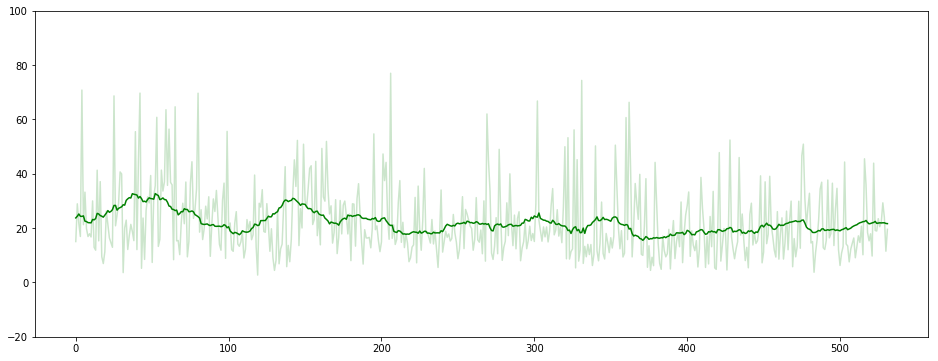

In [81]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_ylim((-20, 100))
ax.plot(hrv_over_time, "g", alpha=0.2)
ax.plot(windowed_average(hrv_over_time, 30), "g")

(array([ 43.,  41.,  59.,  61.,  66.,  97., 147., 185., 282., 276., 353.,
        334., 289., 192., 112.,  68.,  36.,  14.,   5.,   2.]),
 array([251. , 257.8, 264.6, 271.4, 278.2, 285. , 291.8, 298.6, 305.4,
        312.2, 319. , 325.8, 332.6, 339.4, 346.2, 353. , 359.8, 366.6,
        373.4, 380.2, 387. ]),
 <a list of 20 Patch objects>)

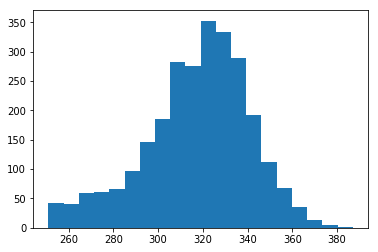

In [85]:
plt.hist(rr_sans_outliers, 20)

## Time Buckets

Analysis of RR peaks divided into hourly buckets

In [95]:
def time_bucket(r_peaks, hours=1):
    # 300hz * 60s * 60m / hours
    ticks = 300 * 60 * 60 / hours
    print(ticks)
    groups = []
    curr_group = []
    curr_hour = 1
    for x in r_peaks:
        if x > curr_hour * ticks:
            groups.append(curr_group)
            curr_group = []
            curr_group.append(x)
            curr_hour += 1
        else:
            curr_group.append(x)
    groups.append(curr_group)
    return groups

In [96]:
groups = time_bucket(list(df["r_peak"]))

1080000.0
